# Intercomparison

**Author:** Ivan Zvonkov

**Last updated:** May 1, 2024

**Description:** Runs intercomparison for Sudan Al Qadarif, Al Jazirah 2022

## 1. Setup

In [ ]:
#earthengine authenticate

In [1]:
import ee
import geemap
import sys
import pandas as pd
import geopandas as gpd
from pathlib import Path

ee.Initialize()

sys.path.append("../..")

from src.compare_covermaps import TARGETS, filter_by_bounds, generate_report, CLASS_COL, COUNTRY_COL
from src.compare_covermaps import TEST_COUNTRIES, TEST_CODE

## 2. Read in evaluation set

In [22]:
df = pd.read_csv("GedarefDarfurAlJazirah2022_gee2.csv")
df = df[df["label"] != 0.5].copy()

# Keep only Al Jazirah and Al Qadarif
df = df[df["longitude"] > 30].copy()

# To fit intercomparison code
df["lon"] = df["longitude"]
df["lat"] = df["latitude"]
df["binary"] = df["label"]

In [23]:
df["subset"].value_counts()

training      176
testing       168
validation    135
Name: subset, dtype: int64

In [24]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs="epsg:4326")

## 3. Run intercomparison

In [25]:
TARGETS = {k:v for k,v in TARGETS.items()}

In [26]:
country = "GedarefDarfurAlJazirah2022"
df["country"] = country
for cropmap in TARGETS.values():
    if country not in cropmap.countries:
        continue
    print(f"[{country}] sampling " + cropmap.title + "...")
    map_sampled = cropmap.extract_test(gdf).copy()
    gdf = pd.merge(gdf, map_sampled, on=["lat", "lon"], how="left")

[GedarefDarfurAlJazirah2022] sampling copernicus...
[GedarefDarfurAlJazirah2022] sampling worldcover-v100...
[GedarefDarfurAlJazirah2022] sampling worldcover-v200...
[GedarefDarfurAlJazirah2022] sampling worldcereal-v100...
[GedarefDarfurAlJazirah2022] sampling glad...
[GedarefDarfurAlJazirah2022] sampling asap...
[GedarefDarfurAlJazirah2022] sampling dynamicworld...
[GedarefDarfurAlJazirah2022] sampling gfsad-gcep...
[GedarefDarfurAlJazirah2022] sampling gfsad-lgrip...
[GedarefDarfurAlJazirah2022] sampling digital-earth-africa...
[GedarefDarfurAlJazirah2022] sampling esa-cci-africa...
[GedarefDarfurAlJazirah2022] sampling globcover-v23...
[GedarefDarfurAlJazirah2022] sampling globcover-v22...
[GedarefDarfurAlJazirah2022] sampling esri-lulc...
[GedarefDarfurAlJazirah2022] sampling nabil-etal-2021...


In [29]:
a_j = {}
for cropmap in TARGETS.values():
    if country not in cropmap.countries:
        continue
    print(f"[{country}] calculating pixel area for " + cropmap.title + "...")
    a_j[cropmap.title] = cropmap.compute_map_area(country, country).copy()
    # compute map area doesn't work as in template. 

[GedarefDarfurAlJazirah2022] calculating pixel area for copernicus...
[GedarefDarfurAlJazirah2022] calculating pixel area for worldcover-v100...
[GedarefDarfurAlJazirah2022] calculating pixel area for worldcover-v200...
[GedarefDarfurAlJazirah2022] calculating pixel area for worldcereal-v100...
[GedarefDarfurAlJazirah2022] calculating pixel area for glad...
[GedarefDarfurAlJazirah2022] calculating pixel area for asap...
[GedarefDarfurAlJazirah2022] calculating pixel area for dynamicworld...
[GedarefDarfurAlJazirah2022] calculating pixel area for gfsad-gcep...
[GedarefDarfurAlJazirah2022] calculating pixel area for gfsad-lgrip...
[GedarefDarfurAlJazirah2022] calculating pixel area for digital-earth-africa...
[GedarefDarfurAlJazirah2022] calculating pixel area for esa-cci-africa...
[GedarefDarfurAlJazirah2022] calculating pixel area for globcover-v23...
[GedarefDarfurAlJazirah2022] calculating pixel area for globcover-v22...
[GedarefDarfurAlJazirah2022] calculating pixel area for esri-lu

In [35]:
comparisons = []
for cropmap in TARGETS.keys():
    if cropmap not in gdf.columns:
        continue
    temp = gdf[[CLASS_COL, cropmap]].dropna()
    comparison = generate_report(cropmap, country, temp[CLASS_COL], temp[cropmap], a_j[cropmap], area_weighted=False)
    comparisons.append(comparison)

results = pd.concat(comparisons).set_index(["dataset"])

# Add ensemble
ensemble_maps = ["glad", "worldcover-v200", "esri-lulc"] # Should be odd number

print(f"Ensemble maps: {ensemble_maps}")
ensemble = gdf[ensemble_maps].mode(axis='columns')
#a_j['ensemble-subset'] = get_ensemble_area(country, [TARGETS[name] for name in ensemble_maps])
comparison = generate_report("ensemble-subset", country, gdf[CLASS_COL], ensemble, a_j['ensemble-subset'], area_weighted=True)
comparisons.append(comparison)

results = pd.concat(comparisons).set_index(["dataset"])
results

/Users/izvonkov/nasaharvest/crop-mask/maps/Sudan/../../src/compare_covermaps.py:701: RuntimeWarning: invalid value encountered in divide
  w_j = a_j / total_px
/Users/izvonkov/nasaharvest/crop-mask/maps/Sudan/../../src/area_utils.py:477: RuntimeWarning: divide by zero encountered in divide
  expr_3 = 1 / n_i_px**2
/Users/izvonkov/nasaharvest/crop-mask/maps/Sudan/../../src/compare_covermaps.py:701: RuntimeWarning: invalid value encountered in divide
  w_j = a_j / total_px
/Users/izvonkov/nasaharvest/crop-mask/maps/Sudan/../../src/area_utils.py:477: RuntimeWarning: divide by zero encountered in divide
  expr_3 = 1 / n_i_px**2
/Users/izvonkov/nasaharvest/crop-mask/maps/Sudan/../../src/compare_covermaps.py:701: RuntimeWarning: invalid value encountered in divide
  w_j = a_j / total_px
/Users/izvonkov/nasaharvest/crop-mask/maps/Sudan/../../src/area_utils.py:477: RuntimeWarning: divide by zero encountered in divide
  expr_3 = 1 / n_i_px**2
/Users/izvonkov/nasaharvest/crop-mask/maps/Sudan/../

Ensemble maps: ['glad', 'worldcover-v200', 'esri-lulc']


KeyError: 'ensemble-subset'

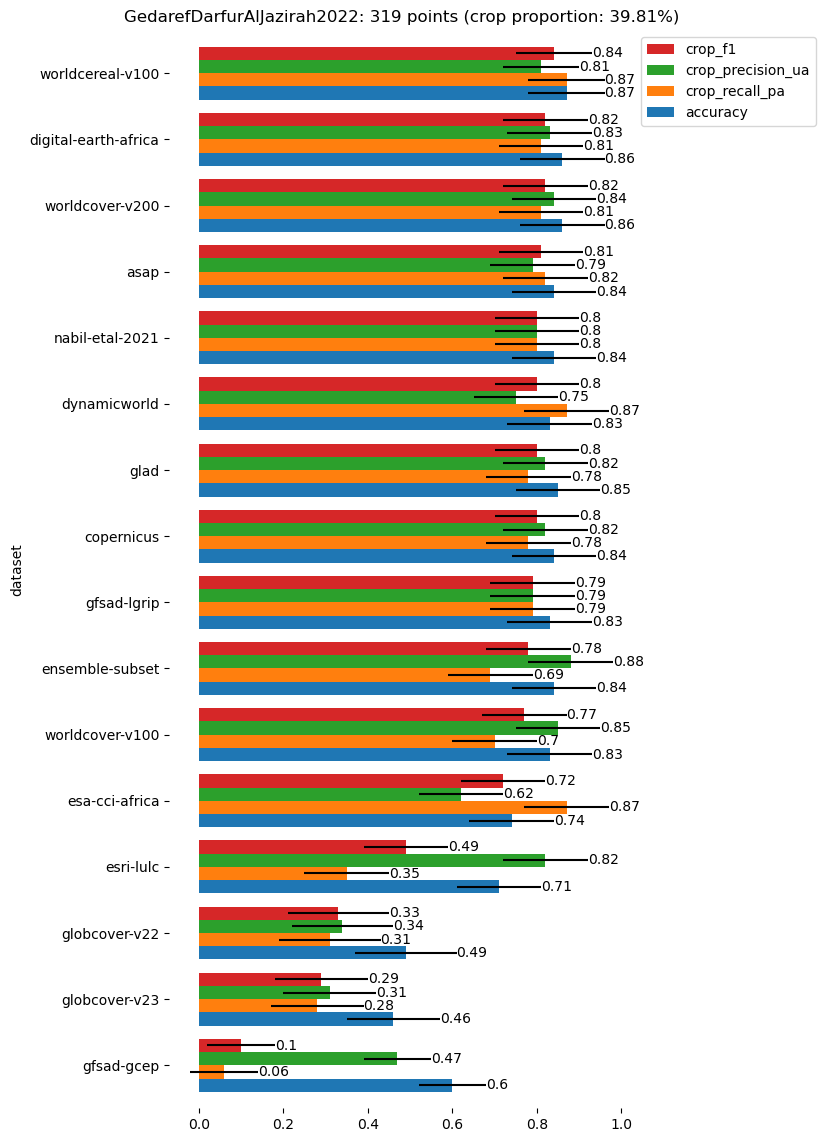

In [11]:
crop_proportion = round(gdf[CLASS_COL].value_counts(normalize=True)[1], 4) * 100
ax = results.sort_values("crop_f1").plot(
    y=["accuracy", "crop_recall_pa", "crop_precision_ua", "crop_f1"], 
    xerr="std_crop_f1",
    kind="barh", 
    figsize=(6, 14),
    width=0.8,
    title=f"{country}: {len(gdf)} points (crop proportion: {crop_proportion}%)",
);

for c in ax.containers[1::2]:
    ax.bar_label(c)

for border in ["top", "right", "bottom", "left"]:
    ax.spines[border].set_visible(False)

ax.legend(bbox_to_anchor=(1, 1), reverse=True);

## 4. Visualize best available map

In [12]:
# Run this cell to view and export map
print("To view and export map copy and paste the text below the dashed line into GEE\n" + "-"*100)
best_dataset = results["crop_f1"].idxmax()

print("var palettes = require('users/gena/packages:palettes');")
print("var classVis = {palette: palettes.cmocean.Speed[7].slice(0,-2)}")
print('''var aoi = ee.FeatureCollection("projects/ee-gmuhawenayo/assets/rois");''')

print("Map.centerObject(aoi, 7);")
if best_dataset in TARGETS:
    print(TARGETS[best_dataset].ee_script(country, include_prefix=False))
else:
    image_var_names = [TARGETS[d].title_safe for d in ensemble_maps]
    for i, dataset in enumerate(ensemble_maps):
        print(TARGETS[dataset].ee_script(country, include_prefix=(i == 0), include_export=False))
        print("\n")
    print(f"var ensemble = ee.ImageCollection.fromImages([{', '.join(image_var_names)}]).mode()")
    print(f"Map.addLayer(ensemble, classVis, 'Cropland from ensemble');")
    print(f"""
Export.image.toCloudStorage({{
    image: ensemble,
    description: "{country}_ensemble_{'_'.join(image_var_names)}",
    bucket: 'crop-mask-preds-merged',
    fileNamePrefix: "{country}_ensemble_{'_'.join(image_var_names)}",
    region: aoi,
    scale: 10,
    crs: "EPSG:4326",
    maxPixels: 1e10,
    skipEmptyTiles: true
}});""")

To view and export map copy and paste the text below the dashed line into GEE
----------------------------------------------------------------------------------------------------
var palettes = require('users/gena/packages:palettes');
var classVis = {palette: palettes.cmocean.Speed[7].slice(0,-2)}
var aoi = ee.FeatureCollection("projects/ee-gmuhawenayo/assets/rois");
Map.centerObject(aoi, 7);
var worldcereal_v100 = ee.ImageCollection(
            ee.ImageCollection("ESA/WorldCereal/2021/MODELS/v100")
            .filter('product == "temporarycrops"')
            .select("classification")
            .mosaic()
        ).filterBounds(aoi).mosaic().clip(aoi);
worldcereal_v100 = worldcereal_v100.eq(100).rename('crop')
Map.addLayer(worldcereal_v100, classVis, 'Cropland from worldcereal-v100');
Export.image.toCloudStorage({
    image: worldcereal_v100,
    description: "GedarefDarfurAlJazirah2022_worldcereal_v100",
    bucket: 'crop-mask-preds-merged',
    fileNamePrefix: 'GedarefDarfurAlJaz